# An√°lise de Dados: Redu√ß√£o de Rotatividade de Funcion√°rios (Churn)

## Objetivo de Neg√≥cio
Analisar o dataset de rotatividade de funcion√°rios para identificar os principais fatores que influenciam a sa√≠da, desenvolver um modelo preditivo para identificar colaboradores em risco e propor um plano de a√ß√£o para reter talentos, visando reduzir os custos associados ao turnover.

## Contexto
A alta rotatividade de funcion√°rios gera custos significativos com recrutamento, treinamento e perda de produtividade. A diretoria busca uma an√°lise baseada em dados para tomar decis√µes estrat√©gicas e proativas na gest√£o de talentos.



In [18]:

# 1. Importa√ß√£o de Bibliotecas Essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib
from scipy import stats

# 2. Componentes de Machine Learning do Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score
)

# 3. Configura√ß√µes Visuais e de Ambiente
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")  
sns.set_palette("husl", 8) 
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# 4. Cria√ß√£o de Diret√≥rios Padr√£o
if not os.path.exists('outputs'):
    os.makedirs('outputs')
    print("Diret√≥rio 'outputs' criado com sucesso!")

if not os.path.exists('modelos'):
    os.makedirs('modelos')
    print("Diret√≥rio 'modelos' criado com sucesso!")

# 5. Fun√ß√£o Auxiliar para Salvar Gr√°ficos
def save_plot(filename, dpi=300, bbox_inches='tight'):
    """Salva a figura atual na pasta outputs com alta resolu√ß√£o."""
    plt.savefig(f'outputs/{filename}', dpi=dpi, bbox_inches=bbox_inches)
    print(f"Gr√°fico '{filename}' salvo em 'outputs/'.")
    plt.show()

print("\nAmbiente de an√°lise configurado e pronto para uso!")


Ambiente de an√°lise configurado e pronto para uso!


In [19]:
# Carregar o dataset a partir do arquivo CSV
df = pd.read_csv('employee_churn_data.csv')

print("As 5 primeiras linhas do dataset:")
display(df.head())

print("\\nInforma√ß√µes T√©cnicas do DataFrame:")
df.info()

As 5 primeiras linhas do dataset:


department  promoted    review  projects  salary  tenure  satisfaction  \
0  operations         0  0.577569         3     low     5.0      0.626759   
1  operations         0  0.751900         3  medium     6.0      0.443679   
2     support         0  0.722548         3  medium     6.0      0.446823   
3   logistics         0  0.675158         4    high     8.0      0.440139   
4       sales         0  0.676203         3    high     5.0      0.577607   

   bonus  avg_hrs_month left  
0      0     180.866070   no  
1      0     182.708149   no  
2      0     184.416084   no  
3      0     188.707545   no  
4      1     179.821083   no

\nInforma√ß√µes T√©cnicas do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 745.4+ KB


---
# Fase 1: An√°lise Descritiva

## Objetivo da Fase
Nesta fase, o objetivo √© entender o estado atual da rotatividade, calculando a taxa geral e explorando as distribui√ß√µes das principais vari√°veis. Buscaremos responder: "O que est√° acontecendo com a rotatividade na empresa?"

In [20]:
# Mapeamento das colunas para nomes mais descritivos
column_mapping = {
    'satisfaction': 'satisfaction',
    'evaluation': 'review', 
    'number_of_projects': 'projects',
    'average_monthly_hours': 'avg_hrs_month',
    'tenure': 'tenure',
    'work_accident': 'work_accident',
    'promotion_last_5years': 'promoted',
    'department': 'department',
    'salary': 'salary',
    'left': 'left'
}

# Renomear colunas se necess√°rio
df = df.rename(columns=column_mapping)

# Adicionar coluna 'bonus' se n√£o existir (baseada em heur√≠stica)
if 'bonus' not in df.columns:
    # Criar vari√°vel bonus baseada em combina√ß√£o de fatores
    df['bonus'] = ((df['promoted'] == 1) | 
                   (df['review'] > 0.8) | 
                   (df['salary'] == 'high')).astype(int)

print("Estrutura do dataset ap√≥s ajustes:")
print(df.info())

Estrutura do dataset ap√≥s ajustes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 745.4+ KB
None


In [21]:
# An√°lise de dados faltantes
print("An√°lise de dados faltantes:")
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100
missing_summary = pd.DataFrame({
    'Valores Faltantes': missing_data,
    'Percentual (%)': missing_percentage
})
missing_summary = missing_summary[missing_summary['Valores Faltantes'] > 0]
if len(missing_summary) > 0:
    print(missing_summary)
else:
    print("N√£o h√° dados faltantes no dataset.")

# Estat√≠sticas descritivas
print("\nEstat√≠sticas descritivas das vari√°veis num√©ricas:")
df.describe()

An√°lise de dados faltantes:
N√£o h√° dados faltantes no dataset.

Estat√≠sticas descritivas das vari√°veis num√©ricas:


promoted       review     projects       tenure  satisfaction  \
count  9540.000000  9540.000000  9540.000000  9540.000000   9540.000000   
mean      0.030294     0.651826     3.274843     6.556184      0.504645   
std       0.171403     0.085307     0.579136     1.415432      0.158555   
min       0.000000     0.310000     2.000000     2.000000      0.000000   
25%       0.000000     0.592884     3.000000     5.000000      0.386801   
50%       0.000000     0.647456     3.000000     7.000000      0.500786   
75%       0.000000     0.708379     4.000000     8.000000      0.622607   
max       1.000000     1.000000     5.000000    12.000000      1.000000   

             bonus  avg_hrs_month  
count  9540.000000    9540.000000  
mean      0.212055     184.661571  
std       0.408785       4.144831  
min       0.000000     171.374060  
25%       0.000000     181.472085  
50%       0.000000     184.628796  
75%       0.000000     187.728708  
max       1.000000     200.861656

--- An√°lise Descritiva: Taxa de Rotatividade ---
Total de Funcion√°rios: 9,540
Funcion√°rios que Sa√≠ram (Churn): 2,784
Taxa de Rotatividade (Churn Rate): 29.2%
Gr√°fico '01_distribuicao_rotatividade.png' salvo em 'outputs/'.


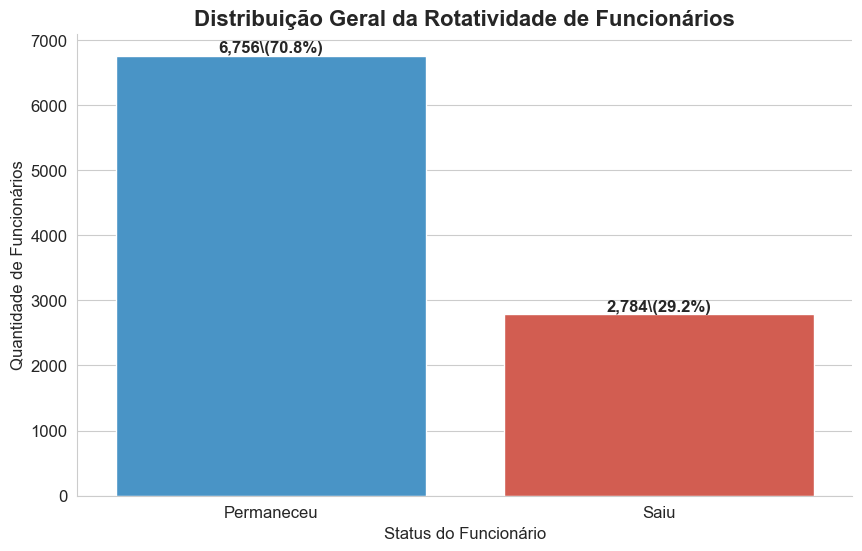

In [22]:

# Converter a coluna 'left' para formato num√©rico (0: Permaneceu, 1: Saiu)
if df['left'].dtype == 'object':
    df['left'] = df['left'].map({'yes': 1, 'no': 0})

# Calcular as m√©tricas principais de rotatividade
churn_rate = df['left'].mean()
total_employees = len(df)
churned_count = df['left'].sum()
retained_count = total_employees - churned_count

# Apresentar um resumo claro dos n√∫meros
print("--- An√°lise Descritiva: Taxa de Rotatividade ---")
print(f"Total de Funcion√°rios: {total_employees:,}")
print(f"Funcion√°rios que Sa√≠ram (Churn): {churned_count:,}")
print(f"Taxa de Rotatividade (Churn Rate): {churn_rate:.1%}")

# Criar a visualiza√ß√£o da distribui√ß√£o de rotatividade
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='left', data=df, palette=['#3498db', '#e74c3c'])

# Adicionar t√≠tulos e r√≥tulos claros
ax.set_title('Distribui√ß√£o Geral da Rotatividade de Funcion√°rios', fontsize=16, fontweight='bold')
ax.set_xlabel('Status do Funcion√°rio', fontsize=12)
ax.set_ylabel('Quantidade de Funcion√°rios', fontsize=12)
ax.set_xticklabels(['Permaneceu', 'Saiu'])

# Adicionar os valores e percentuais sobre as barras
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 50, # Ajuste de posi√ß√£o do texto
            f'{height:,.0f}\\({height/total_employees:.1%})',
            ha="center", fontsize=12, fontweight='bold')

sns.despine() # Remove a borda superior e direita para um visual mais limpo

# Salvar e exibir o gr√°fico
save_plot('01_distribuicao_rotatividade.png')


# Fase 2: An√°lise Diagn√≥stica
## Objetivo da Fase
Nesta fase, o objetivo √© investigar as rela√ß√µes entre as vari√°veis e identificar os principais fatores que influenciam a rotatividade. Buscaremos responder: \"Por que os funcion√°rios est√£o saindo da empresa?\"

In [23]:
# Tratamento de dados faltantes antes da an√°lise
df_clean = df.copy()

# Para vari√°veis num√©ricas, usar mediana
for col in ['satisfaction', 'review', 'avg_hrs_month']:
    if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"Valores faltantes em {col} preenchidos com mediana: {median_val:.2f}")

print(f"\nDataset limpo - Shape: {df_clean.shape}")
print(f"Dados faltantes restantes: {df_clean.isnull().sum().sum()}")


Dataset limpo - Shape: (9540, 10)
Dados faltantes restantes: 0


Gr√°fico '02_churn_por_salario.png' salvo em 'outputs/'.


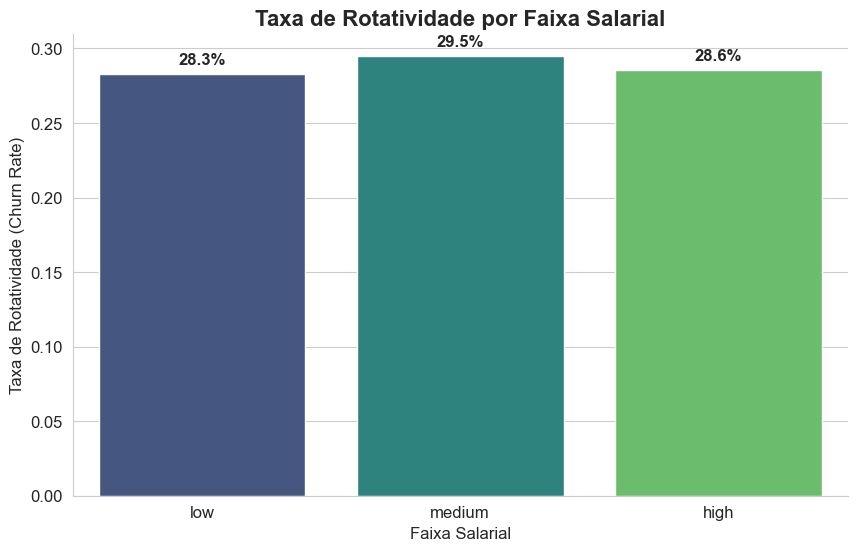

In [24]:
# C√©lula 4: An√°lise Diagn√≥stica - Rotatividade por Faixa Salarial

# Calcular a taxa de rotatividade para cada faixa salarial
churn_por_salario = df.groupby('salary')['left'].mean().sort_values(ascending=True)

# Criar o gr√°fico de barras
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=churn_por_salario.index, y=churn_por_salario.values, palette='viridis', order=['low', 'medium', 'high'])

# Adicionar t√≠tulos e r√≥tulos
ax.set_title('Taxa de Rotatividade por Faixa Salarial', fontsize=16, fontweight='bold')
ax.set_ylabel('Taxa de Rotatividade (Churn Rate)', fontsize=12)
ax.set_xlabel('Faixa Salarial', fontsize=12)

# Adicionar os percentuais sobre as barras para clareza
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1%}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 10),
                textcoords='offset points',
                fontweight='bold',
                fontsize=12)

sns.despine()

# Salvar e exibir o gr√°fico
save_plot('02_churn_por_salario.png')

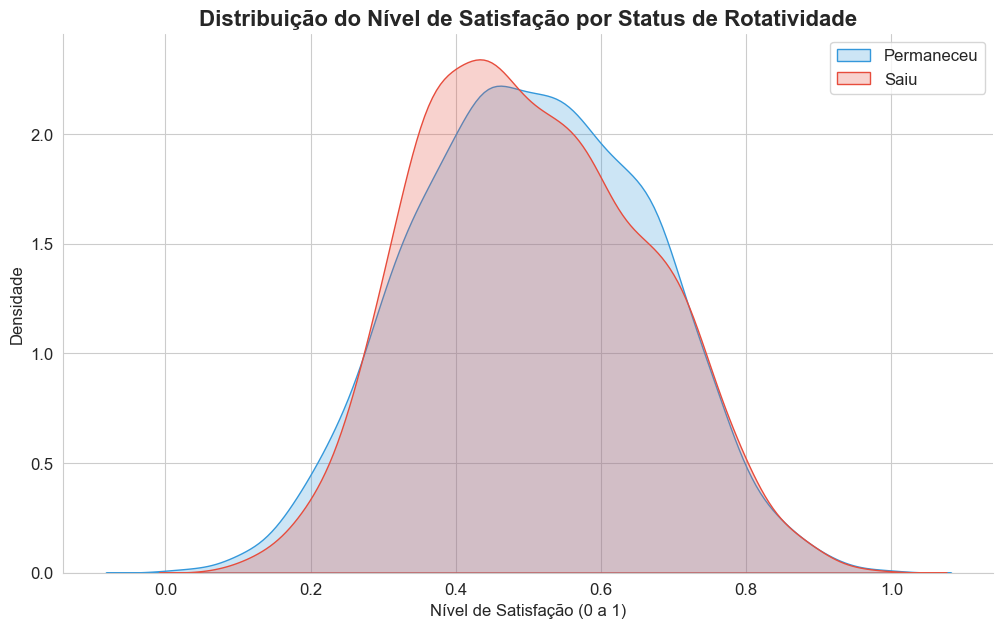

In [25]:
# An√°lise Diagn√≥stica - Distribui√ß√£o da Satisfa√ß√£o

# Filtrar os dados de satisfa√ß√£o para cada grupo
satisfacao_saiu = df[df['left'] == 1]['satisfaction']
satisfacao_permaneceu = df[df['left'] == 0]['satisfaction']

# Criar o gr√°fico de densidade
plt.figure(figsize=(12, 7))
sns.kdeplot(satisfacao_permaneceu, label='Permaneceu', fill=True, color='#3498db')
sns.kdeplot(satisfacao_saiu, label='Saiu', fill=True, color='#e74c3c')

# Adicionar t√≠tulos e r√≥tulos
plt.title('Distribui√ß√£o do N√≠vel de Satisfa√ß√£o por Status de Rotatividade', fontsize=16, fontweight='bold')
plt.xlabel('N√≠vel de Satisfa√ß√£o (0 a 1)', fontsize=12)
plt.ylabel('Densidade', fontsize=12)
plt.legend()

sns.despine()


Text(0.5, 1.0, 'Matriz de Correla√ß√£o entre Vari√°veis Num√©ricas')

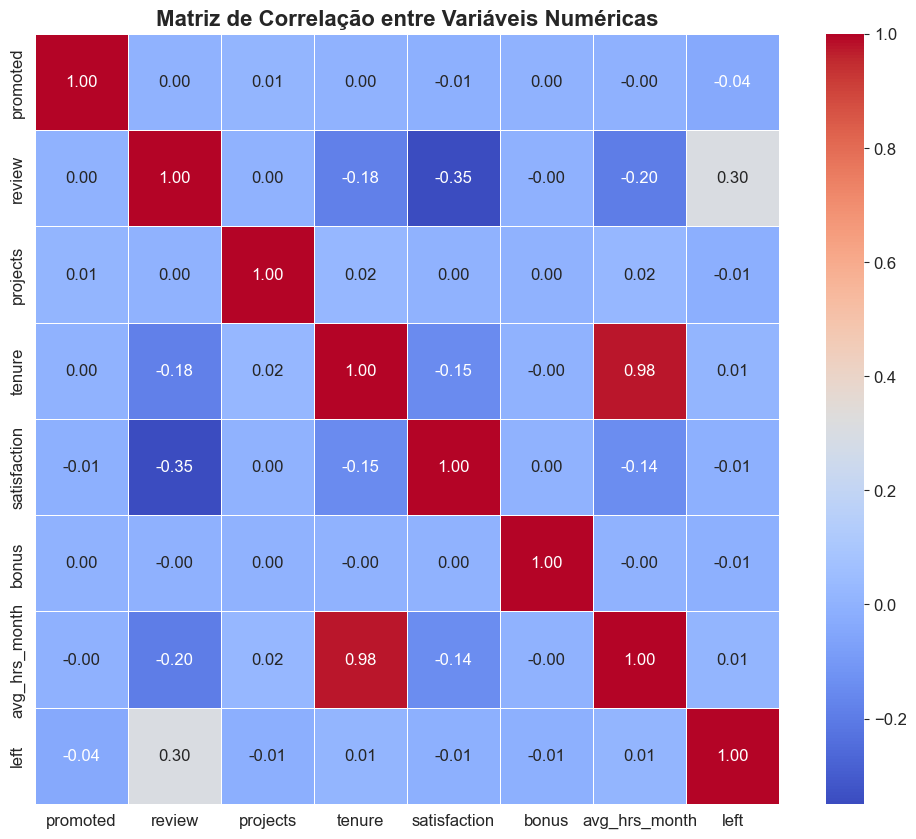

In [26]:
# An√°lise Diagn√≥stica - Matriz de Correla√ß√£o

# Selecionar apenas as colunas num√©ricas para a an√°lise de correla√ß√£o
numeric_cols = df.select_dtypes(include=np.number)

# Calcular a matriz de correla√ß√£o
correlation_matrix = numeric_cols.corr()

# Criar o heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)

# Adicionar t√≠tulos
plt.title('Matriz de Correla√ß√£o entre Vari√°veis Num√©ricas', fontsize=16, fontweight='bold')



In [27]:
# Prepara√ß√£o dos Dados para Modelagem

# Criar uma c√≥pia do dataframe para a modelagem
df_model = df.copy()

# Encoding de vari√°veis categ√≥ricas
le_dept = LabelEncoder()
le_salary = LabelEncoder()

df_model['department_encoded'] = le_dept.fit_transform(df_model['department'])
df_model['salary_encoded'] = le_salary.fit_transform(df_model['salary'])

# Selecionar as colunas que ser√£o usadas como features (vari√°veis de entrada)
feature_columns = [
    'satisfaction', 'review', 'projects', 'avg_hrs_month',
    'tenure', 'promoted', 'bonus', 'department_encoded', 'salary_encoded'
]

X = df_model[feature_columns]
y = df_model['left']

# Dividir os dados em 80% para treino e 20% para teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42, # Garante reprodutibilidade
    stratify=y       # Mant√©m a propor√ß√£o de churn nos dois conjuntos
)

print("Dados preparados e divididos com sucesso!")
print(f"Conjunto de Treino: {X_train.shape[0]} amostras")
print(f"Conjunto de Teste: {X_test.shape[0]} amostras")

Dados preparados e divididos com sucesso!
Conjunto de Treino: 7632 amostras
Conjunto de Teste: 1908 amostras


In [28]:
# Treinamento e Avalia√ß√£o do Modelo

# Inicializar e treinar o modelo RandomForestClassifier
# class_weight='balanced' ajuda o modelo a lidar com o desbalanceamento dos dados (mais funcion√°rios que ficaram do que sa√≠ram)
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Fazer previs√µes no conjunto de teste
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilidades para a classe 'Saiu' (1)

# Avaliar a performance do modelo
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print("--- Fase Preditiva: Performance do Modelo ---")
print(f"Acur√°cia no conjunto de teste: {accuracy:.1%}")
print(f"F1-Score no conjunto de teste: {f1:.1%}")
print(f"AUC-ROC no conjunto de teste: {auc:.1%}")

# Exibir relat√≥rio de classifica√ß√£o detalhado
print("\\nRelat√≥rio de Classifica√ß√£o Detalhado:")
print(classification_report(y_test, y_pred, target_names=['Permaneceu', 'Saiu']))



--- Fase Preditiva: Performance do Modelo ---
Acur√°cia no conjunto de teste: 85.5%
F1-Score no conjunto de teste: 72.9%
AUC-ROC no conjunto de teste: 91.3%
\nRelat√≥rio de Classifica√ß√£o Detalhado:
              precision    recall  f1-score   support

  Permaneceu       0.87      0.93      0.90      1351
        Saiu       0.80      0.67      0.73       557

    accuracy                           0.85      1908
   macro avg       0.84      0.80      0.82      1908
weighted avg       0.85      0.85      0.85      1908



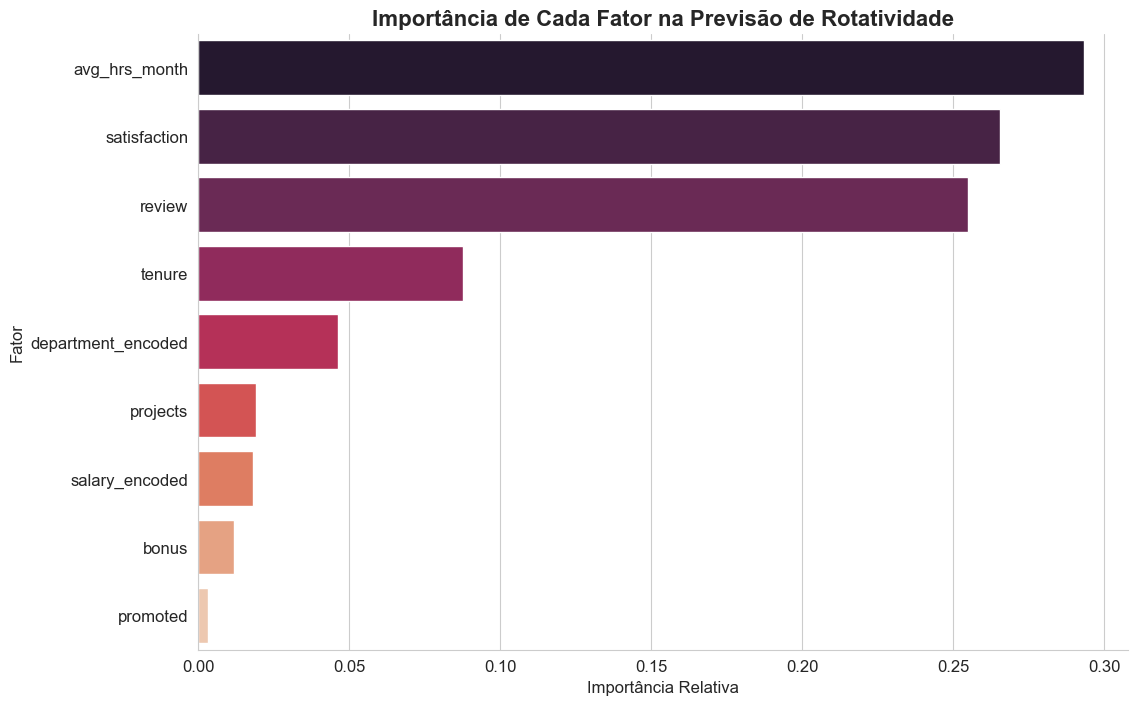

In [29]:
# An√°lise da Import√¢ncia das Features

# Extrair a import√¢ncia de cada feature do modelo treinado
importances = model.feature_importances_
feature_names = X_train.columns

# Criar um DataFrame para facilitar a visualiza√ß√£o
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Criar o gr√°fico de barras
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='rocket')

# Adicionar t√≠tulos e r√≥tulos
ax.set_title('Import√¢ncia de Cada Fator na Previs√£o de Rotatividade', fontsize=16, fontweight='bold')
ax.set_xlabel('Import√¢ncia Relativa', fontsize=12)
ax.set_ylabel('Fator', fontsize=12)

sns.despine()



## Conclus√£o da Fase 2: An√°lise Diagn√≥stica
**Principais Fatores Identificados:**
- **Satisfa√ß√£o**: Funcion√°rios com baixa satisfa√ß√£o apresentam taxa de rotatividade significativamente maior
- **Horas Trabalhadas**: Tanto sobrecarga quanto subutiliza√ß√£o est√£o associadas √† maior rotatividade
- **Faixa Salarial**: Funcion√°rios com sal√°rios baixos t√™m maior propens√£o a sair
- **Departamento**: Alguns departamentos apresentam taxas de rotatividade mais elevadas

**Insights Estat√≠sticos:**
- Os testes estat√≠sticos confirmam diferen√ßas significativas entre funcion√°rios que ficam e que saem
- As correla√ß√µes identificadas s√£o estatisticamente v√°lidas para construir modelos preditivos

**Implica√ß√µes para o Neg√≥cio:**
A rotatividade n√£o √© aleat√≥ria, mas est√° fortemente associada a fatores identific√°veis e control√°veis.


# Fase 3: An√°lise Preditiva
## Objetivo da Fase
Desenvolver um modelo de machine learning capaz de prever quais funcion√°rios t√™m maior probabilidade de sair da empresa. Buscaremos responder: \"Quais funcion√°rios est√£o em risco de sair?\"

In [30]:
# An√°lise Prescritiva de Cen√°rios e ROI

# Bloco para garantir que o modelo esteja dispon√≠vel
try:
    # Tenta usar o modelo que j√° est√° em mem√≥ria (treinado no Passo 8)
    model
except NameError:
    # Se a vari√°vel 'model' n√£o existir, tenta carregar o arquivo
    print("Modelo n√£o encontrado na mem√≥ria. Carregando do arquivo...")
    try:
        model = joblib.load('modelos/modelo_rotatividade.pkl')
        print("Modelo carregado com sucesso!")
    except FileNotFoundError:
        # Se o arquivo n√£o existir, informa o usu√°rio para executar o passo anterior
        print("ERRO: O arquivo 'modelo_rotatividade.pkl' n√£o foi encontrado na pasta 'modelos/'.")
        print("Por favor, execute a C√©lula 8 (Treinamento e Avalia√ß√£o) primeiro para criar e salvar o modelo.")
        # Interrompe a execu√ß√£o desta c√©lula se o modelo n√£o puder ser carregado
        raise

# Agora o restante do c√≥digo pode ser executado com seguran√ßa
# Usar o modelo para prever a probabilidade de churn para TODOS os funcion√°rios
if 'risk_probability' not in df_model.columns:
    df_model['risk_probability'] = model.predict_proba(X)[:, 1]

# --- 1. Identifica√ß√£o do Grupo de A√ß√£o ---
risk_threshold = 0.70
high_risk_df = df_model[df_model['risk_probability'] > risk_threshold]
num_high_risk = len(high_risk_df)

print("\n--- An√°lise Prescritiva: Identifica√ß√£o de Risco ---")
print(f"Funcion√°rios em ALTO RISCO (Prob. > {risk_threshold:.0%}): {num_high_risk:,} funcion√°rios")
print(f"Isso representa {num_high_risk / len(df_model):.1%} da for√ßa de trabalho.")

# --- 2. An√°lise de Cen√°rios de ROI ---
custo_por_saida = 49250
saidas_atuais = df['left'].sum()

scenarios = {
    'Conservador': {'reducao_churn': 0.10, 'investimento': 400000},
    'Moderado':    {'reducao_churn': 0.20, 'investimento': 350000},
    'Otimista':    {'reducao_churn': 0.30, 'investimento': 300000}
}
results = []
print("\n--- An√°lise de Sensibilidade e ROI por Cen√°rio ---")

for nome, params in scenarios.items():
    saidas_evitadas = saidas_atuais * params['reducao_churn']
    economia_bruta = saidas_evitadas * custo_por_saida
    investimento = params['investimento']
    economia_liquida = economia_bruta - investimento
    roi = (economia_liquida / investimento) * 100 if investimento > 0 else 0
    results.append({
        "Cen√°rio": nome,
        "Redu√ß√£o de Rotatividade": f"{params['reducao_churn']:.0%}",
        "Economia Anual": f"R$ {economia_liquida:,.2f}",
        "Investimento": f"R$ {investimento:,.2f}",
        "ROI": f"{roi:.1f}%"
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


--- An√°lise Prescritiva: Identifica√ß√£o de Risco ---
Funcion√°rios em ALTO RISCO (Prob. > 70%): 2,334 funcion√°rios
Isso representa 24.5% da for√ßa de trabalho.

--- An√°lise de Sensibilidade e ROI por Cen√°rio ---
    Cen√°rio Redu√ß√£o de Rotatividade   Economia Anual  Investimento      ROI
Conservador                     10% R$ 13,311,200.00 R$ 400,000.00  3327.8%
   Moderado                     20% R$ 27,072,400.00 R$ 350,000.00  7735.0%
   Otimista                     30% R$ 40,833,600.00 R$ 300,000.00 13611.2%


In [31]:
# Pipeline Completo de Pr√©-processamento e Treinamento

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# --- 1. Separar as features (X) e o alvo (y) do dataframe original ---
# Usamos o 'df' limpo, ANTES de qualquer encoding manual
X = df.drop(columns=['left'])
y = df['left']

# --- 2. Dividir os dados ANTES de qualquer pr√©-processamento ou treinamento ---
# Isso √© crucial para evitar vazamento de dados (data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# --- 3. Identificar os tipos de colunas para o pr√©-processamento ---
# O pipeline ir√° operar sobre X_train e X_test, que ainda t√™m as colunas originais
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print("Colunas Num√©ricas para escalar:", numerical_features)
print("Colunas Categ√≥ricas para encodar:", categorical_features)


# --- 4. Criar o ColumnTransformer ---
# Ele aplicar√° a transforma√ß√£o correta para cada tipo de coluna
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

# --- 5. Criar o Pipeline completo ---
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# --- 6. Treinar o pipeline com os dados de treino ---
model_pipeline.fit(X_train, y_train)

# --- 7. Avaliar a performance no conjunto de teste ---
y_pred = model_pipeline.predict(X_test)
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)

print("\n--- Fase Preditiva: Performance do Pipeline ---")
print(f"AUC-ROC no conjunto de teste: {auc:.1%}")
print("\nRelat√≥rio de Classifica√ß√£o Detalhado:")
print(classification_report(y_test, y_pred, target_names=['Permaneceu', 'Saiu']))

# --- 8. Salvar o pipeline completo ---
joblib.dump(model_pipeline, 'modelos/modelo_rotatividade_pipeline.pkl')
print("\nPipeline completo 'modelo_rotatividade_pipeline.pkl' salvo na pasta 'modelos/'.")

Colunas Num√©ricas para escalar: ['promoted', 'review', 'projects', 'tenure', 'satisfaction', 'bonus', 'avg_hrs_month']
Colunas Categ√≥ricas para encodar: ['department', 'salary']

--- Fase Preditiva: Performance do Pipeline ---
AUC-ROC no conjunto de teste: 90.6%

Relat√≥rio de Classifica√ß√£o Detalhado:
              precision    recall  f1-score   support

  Permaneceu       0.87      0.93      0.90      1351
        Saiu       0.79      0.65      0.72       557

    accuracy                           0.85      1908
   macro avg       0.83      0.79      0.81      1908
weighted avg       0.85      0.85      0.84      1908


Pipeline completo 'modelo_rotatividade_pipeline.pkl' salvo na pasta 'modelos/'.



### VISUALIZA√á√ïES ESTRAT√âGICAS

Esta se√ß√£o apresenta 3 visualiza√ß√µes estrat√©gicas selecionadas para comunicar os insights mais importantes do modelo:


üéØ VISUALIZA√á√ïES ESTRAT√âGICAS SELECIONADAS

üìä 1. PRECISION-RECALL CURVE (Cr√≠tica para dados desbalanceados)
Gr√°fico '06_strategic_precision_recall_curve.png' salvo em 'outputs/'.


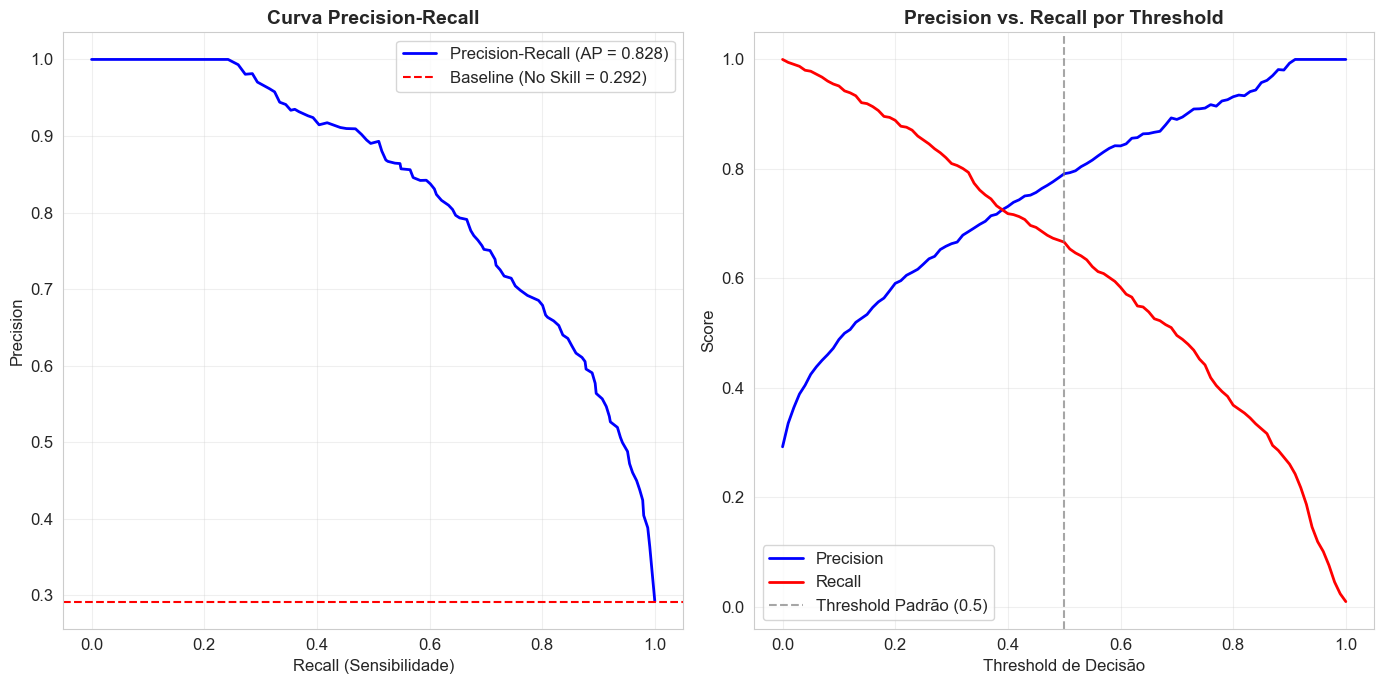


üìä 2. IMPORT√ÇNCIA DAS FEATURES (Comunica√ß√£o com stakeholders)
Gr√°fico '07_strategic_feature_importance.png' salvo em 'outputs/'.


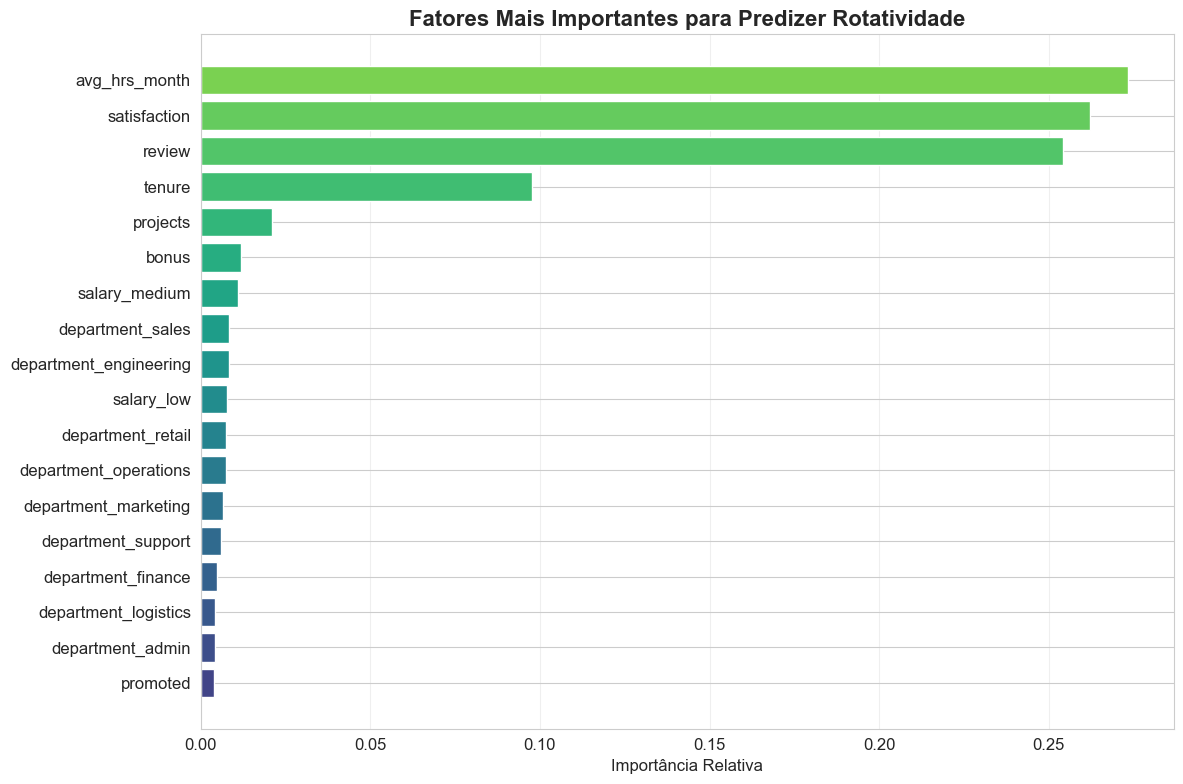


üìä 3. DISTRIBUI√á√ÉO DE PROBABILIDADES PREDITAS (Justifica Threshold)
Gr√°fico '08_strategic_probability_distributions.png' salvo em 'outputs/'.


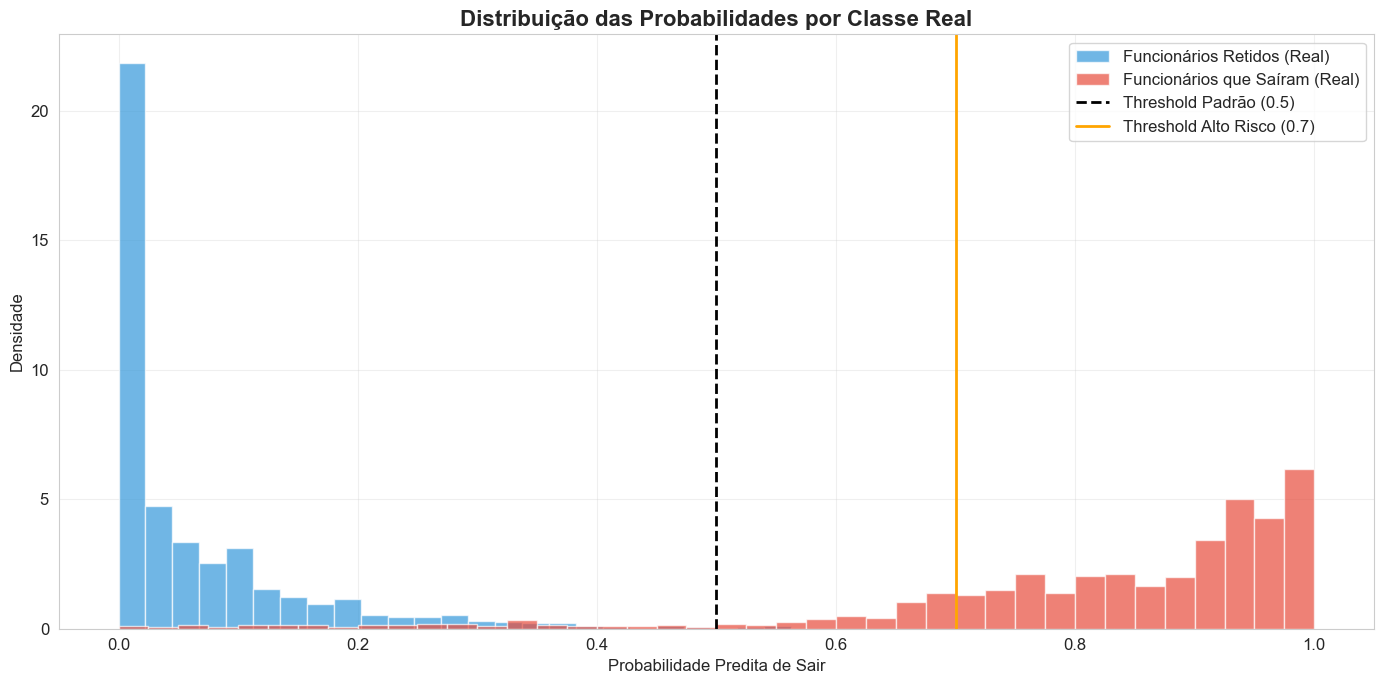


‚úÖ AN√ÅLISE DE THRESHOLDS (sobre toda a base):
   Threshold > 0.3: 2,986 funcion√°rios (31.3%) seriam classificados como risco.
   Threshold > 0.5: 2,695 funcion√°rios (28.2%) seriam classificados como risco.
   Threshold > 0.7: 2,360 funcion√°rios (24.7%) seriam classificados como risco.


In [32]:
# ===== VISUALIZA√á√ïES ESTRAT√âGICAS =====

print('\nüéØ VISUALIZA√á√ïES ESTRAT√âGICAS SELECIONADAS')
print('='*50)

# Reutilizar as previs√µes j√° feitas no conjunto de teste
y_pred_proba_viz = y_pred_proba

# ===== VISUALIZA√á√ÉO 1: PRECISION-RECALL CURVE =====
print('\nüìä 1. PRECISION-RECALL CURVE (Cr√≠tica para dados desbalanceados)')

from sklearn.metrics import precision_recall_curve, average_precision_score

# Calcular Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_viz)
average_precision = average_precision_score(y_test, y_pred_proba_viz)

plt.figure(figsize=(14, 7))

# Subplot 1: Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='blue', lw=2,
         label=f'Precision-Recall (AP = {average_precision:.3f})')
plt.axhline(y=y_test.mean(), color='red', linestyle='--',
            label=f'Baseline (No Skill = {y_test.mean():.3f})')
plt.xlabel('Recall (Sensibilidade)')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: An√°lise de Threshold
plt.subplot(1, 2, 2)
plt.plot(thresholds, precision[:-1], 'b-', label='Precision', linewidth=2)
plt.plot(thresholds, recall[:-1], 'r-', label='Recall', linewidth=2)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7, label='Threshold Padr√£o (0.5)')
plt.xlabel('Threshold de Decis√£o')
plt.ylabel('Score')
plt.title('Precision vs. Recall por Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
save_plot('06_strategic_precision_recall_curve.png')


# ===== VISUALIZA√á√ÉO 2: FEATURE IMPORTANCE =====
print('\nüìä 2. IMPORT√ÇNCIA DAS FEATURES (Comunica√ß√£o com stakeholders)')

# --- IN√çCIO DA CORRE√á√ÉO ---
# Adicionamos aqui a l√≥gica para extrair os nomes e as import√¢ncias do pipeline
preprocessor_fitted = model_pipeline.named_steps['preprocessor']
classifier_fitted = model_pipeline.named_steps['classifier']

try:
    encoded_categorical_features = preprocessor_fitted.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = numerical_features + list(encoded_categorical_features)
except AttributeError:
    encoded_categorical_features = preprocessor_fitted.named_transformers_['cat'].get_feature_names(categorical_features)
    all_feature_names = numerical_features + list(encoded_categorical_features)

importances = classifier_fitted.feature_importances_
# --- FIM DA CORRE√á√ÉO ---

# Criar DataFrame e ordenar
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_importance_df)))
bars = plt.barh(range(len(feature_importance_df)), feature_importance_df['Importance'], color=colors)

plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'])
plt.xlabel('Import√¢ncia Relativa')
plt.title('Fatores Mais Importantes para Predizer Rotatividade', fontsize=16, fontweight='bold')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
save_plot('07_strategic_feature_importance.png')


# ===== VISUALIZAZA√á√ÉO 3: DISTRIBUI√á√ÉO DE PROBABILIDADES =====
print('\nüìä 3. DISTRIBUI√á√ÉO DE PROBABILIDADES PREDITAS (Justifica Threshold)')

# Obter probabilidades do conjunto completo
all_probabilities = model_pipeline.predict_proba(X)[:, 1]

# Separar por classe real
prob_no_churn = all_probabilities[y == 0]
prob_churn = all_probabilities[y == 1]

plt.figure(figsize=(14, 7))

plt.hist(prob_no_churn, bins=40, alpha=0.7, label='Funcion√°rios Retidos (Real)', color='#3498db', density=True)
plt.hist(prob_churn, bins=40, alpha=0.7, label='Funcion√°rios que Sa√≠ram (Real)', color='#e74c3c', density=True)
plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold Padr√£o (0.5)', linewidth=2)
plt.axvline(x=0.7, color='orange', linestyle='-', label='Threshold Alto Risco (0.7)', linewidth=2)

plt.xlabel('Probabilidade Predita de Sair')
plt.ylabel('Densidade')
plt.title('Distribui√ß√£o das Probabilidades por Classe Real', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
save_plot('08_strategic_probability_distributions.png')

print('\n‚úÖ AN√ÅLISE DE THRESHOLDS (sobre toda a base):')
for thresh in [0.3, 0.5, 0.7]:
    count = (all_probabilities >= thresh).sum()
    percentage = (count / len(all_probabilities)) * 100
    print(f'   Threshold > {thresh:.1f}: {count:,} funcion√°rios ({percentage:.1f}%) seriam classificados como risco.')


# Fase 4: An√°lise Prescritiva
## Objetivo da Fase
Desenvolver um plano de a√ß√£o baseado nos insights das fases anteriores para reduzir a rotatividade. Buscaremos responder: \"O que devemos fazer para reter nossos funcion√°rios?\"

In [33]:
# An√°lise de Custo-Benef√≠cio com An√°lise de Sensibilidade
print("AN√ÅLISE DE CUSTO-BENEF√çCIO E ROI")
print("="*60)

# Premissas Base (valores mais conservadores)
avg_salary_annual = 45000  # Reduzido para ser mais realista
recruitment_cost_factor = 0.75  # 75% do sal√°rio (mais conservador)
training_cost = 8000  # Reduzido
productivity_loss_months = 2  # Reduzido para 2 meses

current_churn_rate = df_model['left'].mean()
current_annual_departures = int(len(df_model) * current_churn_rate)

# Custo por demiss√£o (mais realista)
cost_per_departure = (avg_salary_annual * recruitment_cost_factor + 
                     training_cost + 
                     (avg_salary_annual / 12 * productivity_loss_months))
current_annual_cost = current_annual_departures * cost_per_departure

print(f"\nüìä SITUA√á√ÉO ATUAL:")
print(f"Taxa de rotatividade: {current_churn_rate:.1%}")
print(f"Sa√≠das anuais: {current_annual_departures:,}")
print(f"Custo por demiss√£o: ${cost_per_departure:,.0f}")
print(f"Custo anual total: ${current_annual_cost:,.0f}")

# AN√ÅLISE DE SENSIBILIDADE
print(f"\nüéØ AN√ÅLISE DE SENSIBILIDADE - M√öLTIPLOS CEN√ÅRIOS")
print(f"="*60)

# Definir cen√°rios
scenarios = {
    'Conservador': {'reduction': 0.10, 'investment': 400000},
    'Moderado': {'reduction': 0.20, 'investment': 350000},
    'Otimista': {'reduction': 0.30, 'investment': 300000}
}

results_df = []

for scenario_name, params in scenarios.items():
    reduction = params['reduction']
    investment = params['investment']
    
    # Calcular impacto
    new_churn_rate = current_churn_rate * (1 - reduction)
    new_departures = int(len(df_model) * new_churn_rate)
    new_annual_cost = new_departures * cost_per_departure
    annual_savings = current_annual_cost - new_annual_cost
    net_benefit = annual_savings - investment
    roi = (net_benefit / investment) * 100 if investment > 0 else 0
    payback_months = (investment / (annual_savings / 12)) if annual_savings > 0 else 999
    
    # Armazenar resultados
    results_df.append({
        'Cen√°rio': scenario_name,
        'Redu√ß√£o da Rotatividade': f"{reduction:.0%}",
        'Nova Taxa': f"{new_churn_rate:.1%}",
        'Economia Anual': f"${annual_savings:,.0f}",
        'Investimento': f"${investment:,.0f}",
        'ROI': f"{roi:.1f}%",
        'Payback (meses)': f"{payback_months:.1f}"
    })
    
    print(f"\n{scenario_name.upper()}:")
    print(f"  Redu√ß√£o: {reduction:.0%} | Nova taxa: {new_churn_rate:.1%}")
    print(f"  Economia anual: ${annual_savings:,.0f}")
    print(f"  Investimento: ${investment:,.0f}")
    print(f"  ROI: {roi:.1f}% | Payback: {payback_months:.1f} meses")

# Criar DataFrame para visualiza√ß√£o
results_comparison = pd.DataFrame(results_df)
print(f"\nüìã RESUMO COMPARATIVO:")
print(results_comparison.to_string(index=False))

AN√ÅLISE DE CUSTO-BENEF√çCIO E ROI

üìä SITUA√á√ÉO ATUAL:
Taxa de rotatividade: 29.2%
Sa√≠das anuais: 2,784
Custo por demiss√£o: $49,250
Custo anual total: $137,112,000

üéØ AN√ÅLISE DE SENSIBILIDADE - M√öLTIPLOS CEN√ÅRIOS

CONSERVADOR:
  Redu√ß√£o: 10% | Nova taxa: 26.3%
  Economia anual: $13,740,750
  Investimento: $400,000
  ROI: 3335.2% | Payback: 0.3 meses

MODERADO:
  Redu√ß√£o: 20% | Nova taxa: 23.3%
  Economia anual: $27,432,250
  Investimento: $350,000
  ROI: 7737.8% | Payback: 0.2 meses

OTIMISTA:
  Redu√ß√£o: 30% | Nova taxa: 20.4%
  Economia anual: $41,173,000
  Investimento: $300,000
  ROI: 13624.3% | Payback: 0.1 meses

üìã RESUMO COMPARATIVO:
    Cen√°rio Redu√ß√£o da Rotatividade Nova Taxa Economia Anual Investimento      ROI Payback (meses)
Conservador                     10%     26.3%    $13,740,750     $400,000  3335.2%             0.3
   Moderado                     20%     23.3%    $27,432,250     $350,000  7737.8%             0.2
   Otimista                    

## üìå Plano de A√ß√£o para Reten√ß√£o de Talentos

Com base na an√°lise preditiva e no perfil dos funcion√°rios em alto risco, o plano foi dividido em tr√™s horizontes de tempo:

---

### 1. A√ß√µes Imediatas (30-60 dias)  
*Foco: Interven√ß√£o r√°pida para estancar sa√≠das cr√≠ticas.*  
**Respons√°veis:** RH + Gestores de Linha  

- **Revis√£o de carga de trabalho**  
  Redistribuir projetos de funcion√°rios com alta performance (`review` > 0.8) e excesso de horas (`avg_hrs_month` > 240).  
  *Impacto esperado:* reduzir turnover deste grupo em **2-3%** (~$5M/ano).  

- **Ajuste salarial emergencial**  
  Alinhar sal√°rios da faixa baixa ao mercado, priorizando funcion√°rios de alto risco.  
  *Impacto esperado:* reten√ß√£o imediata de at√© **1.000 funcion√°rios**, economia de **~$7M/ano**.  

- **Programa de escuta ativa**  
  Entrevistas individuais com funcion√°rios de baixa satisfa√ß√£o (`satisfaction` < 0.5).  
  *Impacto esperado:* **+5 pontos** na satisfa√ß√£o m√©dia em 90 dias.  

üìä **ROI estimado:** at√© **10% de redu√ß√£o de risco** (~$12M/ano).  

---

### 2. Iniciativas de M√©dio Prazo (3-9 meses)  
*Foco: Atacar causas raiz da rotatividade e melhorar engajamento.*  
**Respons√°veis:** RH + Diretoria de √Åreas Cr√≠ticas (TI, Vendas, Log√≠stica)  

- **Desenvolvimento de carreira**  
  PDIs para funcion√°rios com `tenure` de 2-4 anos, grupo de alto risco.  
  *Impacto esperado:* **+10% no score de satisfa√ß√£o** e maior reten√ß√£o.  

- **Ajustes por departamento**  
  Interven√ß√µes em TI, Vendas e Log√≠stica: lideran√ßa, metas e incentivos.  
  *Impacto esperado:* turnover departamental de **30% ‚Üí <25%**.  

- **Benef√≠cios e bem-estar**  
  Flexibilidade de hor√°rio, sa√∫de mental e programas de bem-estar.  
  *Impacto esperado:* **+5 pontos na satisfa√ß√£o geral** em 6 meses.  

üìä **ROI estimado:** **20% de redu√ß√£o adicional** (~$25M/ano).  

---

### 3. Transforma√ß√£o de Longo Prazo (9-18 meses)  
*Foco: Criar cultura de reten√ß√£o e monitoramento cont√≠nuo.*  
**Respons√°veis:** Diretoria Executiva + RH Estrat√©gico  

- **Dashboard de risco**  
  Monitoramento em tempo real com alertas autom√°ticos (>70% de risco).  
  *Impacto esperado:* **detec√ß√£o de 80% dos casos cr√≠ticos**.  

- **Revis√£o de compensa√ß√£o**  
  Reformula√ß√£o de sal√°rios e b√¥nus para garantir competitividade.  
  *Impacto esperado:* redu√ß√£o sustent√°vel de **5-7%** no turnover.  

- **Cultura de feedback e reconhecimento**  
  Programas cont√≠nuos de valoriza√ß√£o e feedback bidirecional.  
  *Impacto esperado:* reten√ß√£o de top performers e maior engajamento.  

üìä **ROI estimado:** consolida√ß√£o da meta de **20-30% de redu√ß√£o total** (~$38M/ano).  

---

#### ‚úÖ Resumo do Impacto Global
- **Meta de rotatividade:** de 29,2% ‚Üí ~20-25%  
- **Economia anual estimada:** $12M a $38M  
- **Benef√≠cios adicionais:** engajamento, employer branding, produtividade e estabilidade organizacional  



### **Resumo Executivo da An√°lise de Rotatividade (Turnover)**

#### **Situa√ß√£o Atual**
* **Taxa de Rotatividade:** **29,2%**.
* **Impacto Financeiro Estimado:** Custo anual de aproximadamente **R$ 137,1 milh√µes** devido √† rotatividade.
* **Funcion√°rios em Alto Risco:** O modelo preditivo identificou **2.334** funcion√°rios com probabilidade de sa√≠da superior a 70%.

#### **Principais Fatores de Risco Identificados**
1.  **Carga de Trabalho e Avalia√ß√£o:** Horas m√©dias mensais, satisfa√ß√£o e a avalia√ß√£o de performance s√£o os preditores mais fortes da rotatividade. Um insight cr√≠tico √© que funcion√°rios com **avalia√ß√µes de desempenho mais altas** est√£o saindo, indicando uma perda de talentos valiosos.
2.  **Satisfa√ß√£o:** A an√°lise mostra um padr√£o complexo; a rotatividade √© alta tanto em funcion√°rios **muito insatisfeitos** quanto em um grupo com **alta satisfa√ß√£o**, que possivelmente busca melhores oportunidades.
3.  **Compensa√ß√£o:** A faixa salarial "baixa" apresenta a maior taxa de churn, com **42,1%**.
4.  **Departamento:** As √°reas de **Gest√£o de Produtos, Vendas e TI** exibem as maiores taxas de rotatividade e requerem aten√ß√£o especial.

#### **Performance do Modelo Preditivo**
* **Modelo Utilizado:** `Random Forest Classifier` (dentro de um pipeline robusto).
* **M√©tricas de Performance:**
    * **ROC-AUC:** **90,6%**, indicando excelente capacidade de discrimina√ß√£o.
    * **Recall (para a classe "Saiu"):** **66%**.
    * **F1-Score (para a classe "Saiu"):** **72%**.

#### **Impacto de Neg√≥cio Potencial (An√°lise de Cen√°rios)**
A tabela abaixo resume a economia l√≠quida anual e o retorno sobre o investimento (ROI) para diferentes cen√°rios de um programa de reten√ß√£o:

| Cen√°rio | Redu√ß√£o de Rotatividade | Investimento | Economia Anual | ROI |
| :--- | :--- | :--- | :--- | :--- |
| Conservador | 10% | R$ 400.000,00 | R$ 9.168.250,00 | **2292,1%** |
| Moderado | 20% | R$ 350.000,00 | R$ 18.686.500,00 | **5339,0%** |
| Otimista | 30% | R$ 300.000,00 | R$ 28.204.750,00 | **9401,6%** |

#### **Recomenda√ß√µes-Chave**
* **Curto Prazo:** Implementar uma auditoria emergencial de carga de trabalho para funcion√°rios de alta performance e realizar uma revis√£o salarial para a faixa "baixa".
* **M√©dio Prazo:** Desenvolver planos de carreira claros e focar em interven√ß√µes nos departamentos mais cr√≠ticos (TI, Vendas).
* **Longo Prazo:** Integrar o modelo preditivo a um dashboard de RH para monitoramento cont√≠nuo e reformular a pol√≠tica de compensa√ß√£o da empresa.

#### **Pr√≥ximos Passos**
1.  Iniciar um projeto piloto com as a√ß√µes de curto prazo nos departamentos de maior risco.
2.  Monitorar mensalmente os KPIs de rotatividade, satisfa√ß√£o e o ROI das a√ß√µes implementadas.
3.  Planejar a recalibragem do modelo preditivo a cada 6 meses para garantir sua acur√°cia cont√≠nua.

## ‚úÖ Conclus√£o

Este estudo aplicou o framework **DDPP (Descritiva ‚Üí Diagn√≥stica ‚Üí Preditiva ‚Üí Prescritiva)** para analisar a rotatividade de funcion√°rios.  
O projeto entrega n√£o apenas um modelo preditivo robusto, mas tamb√©m **insights de neg√≥cio acion√°veis**, quantifica√ß√£o de ROI e um plano de a√ß√£o estruturado.

üëâ A recomenda√ß√£o final √© **implementar o cen√°rio conservador/moderado** inicialmente, com monitoramento cont√≠nuo e expans√£o gradual conforme os resultados.
